#  word2vec, doc2vec и fasttext 


1. word2vec – векторное представление слова
2. как сделать вектор документа?
    * усреднить все вектора слов
    * усреднить все вектора слов с $tf-idf$ весами
    * doc2vec
3. fasttext – векторное представление $n$-грам


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
from sklearn.metrics import *
from sklearn.feature_extraction.text import *
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
random.seed(1228)

%matplotlib inline

Загружаем лемматизированные статьи без стоп-слов и создаем массив текстов

In [2]:
from pymystem3 import Mystem
import re


m = Mystem()


regex = re.compile("[А-Яа-я:=!\)\()A-z\_\%/|]+")

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""



def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "


In [3]:
df_neg = pd.read_csv('datasets/nlp/negative.csv', sep=';', header=None, usecols=[3])
df_pos = pd.read_csv('datasets/nlp/positive.csv', sep=';', header=None, usecols=[3])
df_neg['sent'] = 'neg'
df_pos['sent'] = 'pos'
df = pd.concat([df_neg, df_pos])
df = df[:1000]
df.columns = ['text', 'sent']
df.text = df.text.apply(words_only)
df.text = df.text.apply(lemmatize)

In [4]:
df_pos[3].tolist()[:10]
# df_neg[3].tolist()[:10]

['@first_timee хоть я и школота, но поверь, у нас то же самое :D общество профилирующий предмет типа)',
 'Да, все-таки он немного похож на него. Но мой мальчик все равно лучше:D',
 'RT @KatiaCheh: Ну ты идиотка) я испугалась за тебя!!!',
 'RT @digger2912: "Кто то в углу сидит и погибает от голода, а мы ещё 2 порции взяли, хотя уже и так жрать не хотим" :DD http://t.co/GqG6iuE2…',
 '@irina_dyshkant Вот что значит страшилка :D\nНо блин,посмотрев все части,у тебя создастся ощущение,что авторы курили что-то :D',
 'ну любишь или нет? — Я не знаю кто ты бля:D http://t.co/brf9eNg1U6',
 'RT @SpoonLamer: Ох,900 :D ну это конечно же @twinkleAYO . Чтобы у нее было много друзей, ведь она такая мимими &lt;3',
 'RT @veregijytaqo: У тебя есть ухажёр? Нет - мои уши не кто не жрёт :D',
 'Поприветствуем моего нового читателя @Alexey1789 ;)',
 'Теперь у меня есть частичка Сиднея :) #Sydney #SydneyOperaHouse http://t.co/agnto3CZEi']

In [5]:
df.head()

,text,sent
0,на работа быть полный пиддеса :| и так каждый ...,neg
1,коллега сидеть рубиться в Urban terror а я из ...,neg
2,elina_ post как говорить обещаной три год ждат...,neg
3,желать хороший пол тот и удачный посадка я быт...,neg
4,обновлять за какой то леший surf теперь не раб...,neg


In [6]:
texts = [df.text.iloc[i].split() for i in range(len(df))]

## Обучение модели в gensim

In [7]:
df.text[0]

'на работа быть полный пиддеса :| и так каждый закрытие месяц я же свихиваться так D:'

In [8]:
%%time
from gensim.models import Word2Vec
model = Word2Vec(texts, size=100, window=5, min_count=1, workers=6)
model.save('sent_w2v.model')

C:\Users\adwiz\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


CPU times: total: 1.72 s
Wall time: 1.7 s


In [9]:
# summarize the loaded model
print(model)

Word2Vec(vocab=4255, size=100, alpha=0.025)


In [10]:
# summarize vocabulary
words = list(model.wv.vocab)
print(words)

['на', 'работа', 'быть', 'полный', 'пиддеса', ':|', 'и', 'так', 'каждый', 'закрытие', 'месяц', 'я', 'же', 'свихиваться', 'D:', 'коллега', 'сидеть', 'рубиться', 'в', 'Urban', 'terror', 'а', 'из', 'за', 'долбать', 'винд', 'не', 'мочь', ':(', 'elina_', 'post', 'как', 'говорить', 'обещаной', 'три', 'год', 'ждать', '((', 'желать', 'хороший', 'пол', 'тот', 'удачный', 'посадка', 'очень', 'сильно', 'скучать(', 'http://t', 'co/jCLNzVNv', 'S', 'обновлять', 'какой', 'то', 'леший', 'surf', 'теперь', 'работать', 'простоплеер', 'кот', 'нка', 'вчера', 'носик', 'разбивать', 'плакать', 'расстраиваться', 'juliamayko', 'O_nika', 'and_Possum', 'зайти', 'он', 'опять', 'затихариваться', 'прямо', 'физически', 'страдать', 'когда', 'долго', 'молчать!(((', 'вообще', 'болеть', 'выздоравливать', 'микрофраза', 'учиться', 'срать', 'кирпич', 'режим', 'amp', 'quot', 'нона', 'стоп', 'niwoqisipapy', 'хотеть', 'с', 'ты', 'помириться', 'но', 'сука', 'гордый', 'никогда', 'это', 'сделать!', '(((', 'DNO_OKEANA_A', 'A', 'MOE

Загружаем обученную модель

In [11]:
# from gensim.models import Word2Vec
# model.load('sent_w2v.model')

In [12]:
model.wv.most_similar(":|")

[('час', 0.5049593448638916),
 ('там', 0.5016524791717529),
 ('любить', 0.5015109777450562),
 ('ну', 0.49539440870285034),
 ('еще', 0.49123460054397583),
 ('писать', 0.4899786114692688),
 ('хотеть', 0.4845532178878784),
 ('ведь', 0.4806053042411804),
 ('co/', 0.4793078303337097),
 ('человек', 0.47916752099990845)]

In [13]:
model.wv.most_similar(positive=['хорошо', 'плохой'], negative=['хороший'])

[('жосткий:(', 0.38264960050582886),
 ('реклама', 0.38030463457107544),
 ('от', 0.34154316782951355),
 ('fpM', 0.340378999710083),
 ('любить', 0.34004053473472595),
 ('co/yEC', 0.33743810653686523),
 ('сейчас', 0.3365970849990845),
 ('почему', 0.329714834690094),
 ('еда', 0.3286969065666199),
 ('красный', 0.3285219669342041)]

In [14]:
model.wv.doesnt_match('борщ сметана макароны пирожок консомэ кошка'.split())

C:\Users\adwiz\anaconda3\lib\site-packages\gensim\models\keyedvectors.py:730: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'борщ'

Визуализация пространства слов

In [15]:
top_words = []
from nltk import FreqDist
fd = FreqDist()
for text in texts:
    fd.update(text)
for i in fd.most_common(1000):
    top_words.append(i[0])
    
print(top_words)

['я', 'не', 'и', 'в', ':(', 'что', 'а', 'на', '(', 'быть', 'как', 'RT', 'так', 'ты', 'то', 'с', 'это', 'хотеть', 'у', 'все', 'но', 'он', 'http://t', 'по', 'за', 'весь', 'мочь', 'вот', 'такой', 'ну', 'уже', 'этот', ':', 'мы', '((', 'мой', 'они', 'только', 'завтра', 'блин', 'да', 'нет', 'когда', 'же', 'теперь', 'знать', 'из', 'какой', 'бы', 'она', 'день', 'сегодня', 'еще', 'вообще', 'к', 'от', 'спать', 'кто', 'один', 'просто', 'очень', '(((', 'тоже', 'себя', 'год', 'о', 'вы', 'почему', 'там', 'даже', 'хорошо', 'человек', 'опять', '=(', 'который', 'вс', 'любить', 'делать', 'много', 'надо', 'плохо', 'до', 'потом', 'свой', 'если', 'ждать', 'тот', 'самый', 'ещ', 'час', 'время', 'забывать', 'работа', '!', 'думать', 'со', 'сейчас', 'сделать', 'о_о', 'школа', 'для', 'смотреть', 'сидеть', 'хороший', 'последний', 'пойти', 'идти', 'понимать', 'болеть', 'про', 'где', 'сам', 'ни', 'давать', 'хотя', 'новый', 'co/', 'раз', 'е', 'хотеться', 'находить', 'говорить', 'бояться', 'ничто', 'т', 'ведь', 'чтоб

In [16]:
top_words_vec = model[top_words]

C:\Users\adwiz\AppData\Local\Temp\ipykernel_15016\59830606.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  top_words_vec = model[top_words]


In [17]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=0)
top_words_tsne = tsne.fit_transform(top_words_vec)

In [18]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

p = figure(tools='pan, wheel_zoom, reset, save',
           toolbar_location='above',
           title='word2vec T-SNE for most common words')
source = ColumnDataSource(data=dict(x1=top_words_tsne[:, 0],
                                    x2=top_words_tsne[:, 1],
                                    names=top_words
                                   ))
p.scatter(x='x1', y='x2', size=8, source=source)

labels = LabelSet(x='x1', y='x2', text='names', y_offset=6,
                  text_font_size='8pt', text_color='#555555',
                  source=source, text_align='center')
p.add_layout(labels)

show(p)

Loading BokehJS ...

### Кластеризация слов

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

dist = 1 - cosine_similarity(top_words_vec)

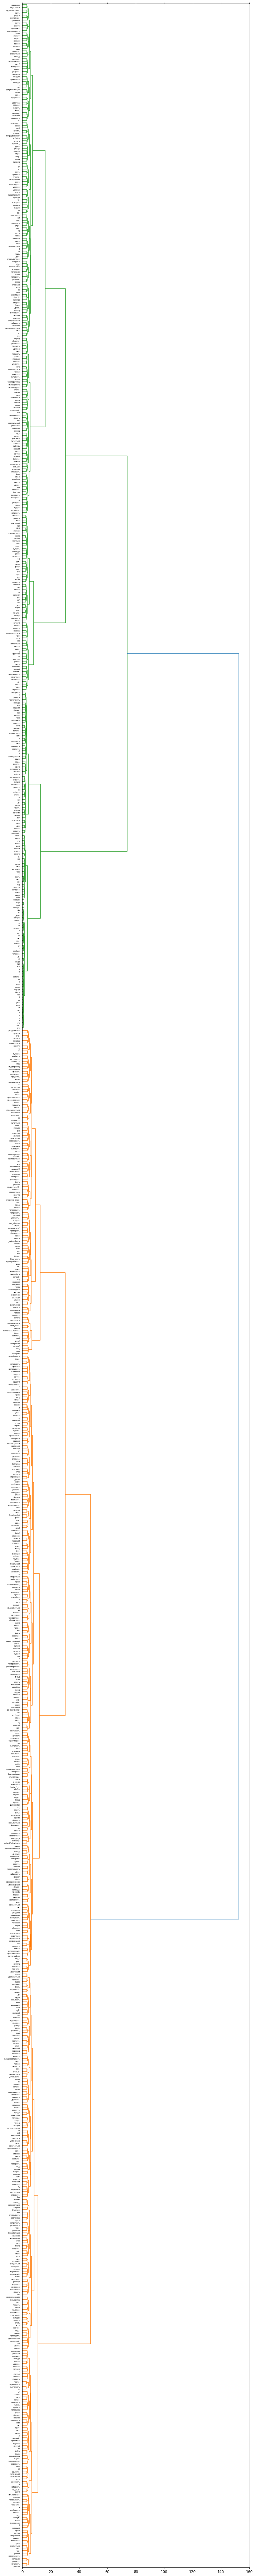

In [20]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist)

fig, ax = plt.subplots(figsize=(10, 100))
ax = dendrogram(linkage_matrix, orientation='right', labels=top_words);

plt.tick_params(\
                axis='x', # changes apply to x-axis
                which='both', # both major and minor ticks are affected
                bottom='off', # ticks along the bottom edge are off
                top='off', # ticks along the top edge are off
                labelbottom='off')
plt.tight_layout()
plt.savefig('w2_clusters.png', dpi=200) #save figure as ward_clusters

## Классификация текстов 

По мотивам http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/

In [21]:
X = df.text.tolist()
y = df.sent.tolist()

X, y = np.array(X), np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33)
print(f'total train examples {len(y_train)}')
print(f'total test examples {len(y_test)}')

total train examples 670
total test examples 330


In [22]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionalityas all the other vectors
        self.dim = len(w2v.popitem()[1])
    
    def fit(self, X, y):
        return self
    
    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                   or [np.zeros(self.dim)], axis=0)
            for word in X
        ])

In [23]:
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(w2v.popitem()[1])
        
    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(x)
        max_idf = max(tfidf.idf_)
        self.word2weight = datadict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
        
        return self
    
    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] * self.word2weight[w]
                    for w in words if w in self.word2vec] or
                   [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [24]:
w2v = dict(zip(model.wv.index2word, model.wv.vectors))

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

rfc_w2v = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)),
    ("extra trees", RandomForestClassifier(n_estimators=20))])
rfc_w2v_tfidf = Pipeline([
    ("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)),
    ("extra trees", RandomForestClassifier(n_estimators=20))])

In [26]:
rfc_w2v.fit(X_train, y_train)
pred = rfc_w2v.predict(X_test)

Precision:   1.00
Recall:   1.00
F1-measure:   1.00
Accuracy:   1.00
              precision    recall  f1-score   support

         neg       1.00      1.00      1.00       330

    accuracy                           1.00       330
   macro avg       1.00      1.00      1.00       330
weighted avg       1.00      1.00      1.00       330



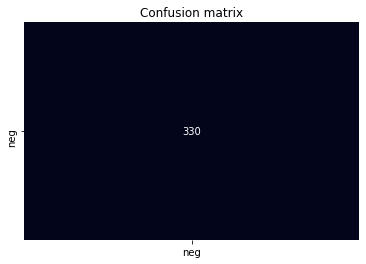

In [27]:
print("Precision: {0:6.2f}".format(precision_score(y_test, pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, pred)))
print(classification_report(y_test, pred))
labels = rfc_w2v.classes_


sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

### paragpaph2vec aka doc2vec

word2vec с дополнительной меткой id документа

In [28]:
from gensim.models.doc2vec import *

In [29]:
splitted_texts = [text.split() for text in X]
idx = [str(i) for i in range(len(X))]

docs = []
for i in range(len(X)):
    docs.append(TaggedDocument(splitted_texts[i], [idx[i]]))

model = Doc2Vec(vector_size=300, window=5, min_count=5, workers=12, alpha=.025, min_alpha=.01, dm=0)
model.build_vocab(docs)

# docvec1 = model.docvecs[0]
# docvecsyn1 = model.docvecs.doctag_syn0[0]
# docsim1 = model.docvecs.most_similar[id1]

model.train(docs, total_examples=len(docs), epochs=20)

In [30]:
class Doc2VecVectorizer(object):
    def __init__(self, d2v_model):
        self.d2v_model = d2v_model
        
    def fit(self, X, y):
        return self
    
    def transform(self, X):
        return np.array([self.d2v_model.infer_vector(text.split()) for text in X])
    

rfc_d2v = Pipeline([
    ('word2vec vectorizer', Doc2VecVectorizer(model)),
    ('extra trees', RandomForestClassifier(n_estimators=20))])

rfc_d2v.fit(X_train, y_train)
pred = rfc_d2v.predict(X_test)

Precision:   1.00
Recall:   1.00
F1-measure:   1.00
Accuracy:   1.00
              precision    recall  f1-score   support

         neg       1.00      1.00      1.00       330

    accuracy                           1.00       330
   macro avg       1.00      1.00      1.00       330
weighted avg       1.00      1.00      1.00       330



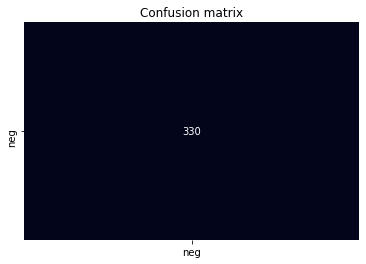

In [31]:
print("Precision: {0:6.2f}".format(precision_score(y_test, pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, pred)))
print(classification_report(y_test, pred))
labels = rfc_w2v.classes_


sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

### fast text

Слово $w$ представляем символьными $n$-грамами: 

$n=3$, $G_{where} = \_wh, whe, her, re\_, \_where\_$

$sim_{w2v}(u,v) = <u,v>$


$sim_{ft}(u,v) = \sum_{e \in G_u} \sum_{g \in G_v} <e,v>$


https://github.com/facebookresearch/fasttext


In [32]:
import fasttext

with open('datasets/nlp/data.train.txt', 'w+') as outfile:
    for i in range(len(X_train)):
        outfile.write('__label__' + y_train[i] + ' ' + X_train[i] +  '\n')

with open('datasets/nlp/test.txt', 'w+') as outfile:
    for i in range(len(X_test)):
        outfile.write('__label__' + y_test[i] + ' ' + X_test[i] +  '\n')

In [33]:
classifier = fasttext.train_supervised('datasets/nlp/data.train.txt', lr=1.0, epoch=25)
result = classifier.test('datasets/nlp/test.txt')

def print_results(N, p, r):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(1, p))
    print("R@{}\t{:.3f}".format(1, r))

print_results(*classifier.test('datasets/nlp/test.txt'))

N	330
P@1	1.000
R@1	1.000


In [34]:
for item in name_list:
    item = item.replace("\n"," ")
    pred = classifier.predict(item)


print("Precision: {0:6.2f}".format(precision_score(y_test, pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, pred)))
print(classification_report(y_test, pred))
labels = rfc_w2v.classes_


sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

NameError: name 'name_list' is not defined